# Image Filtering with Linear Filters
*Author: David Fouhey*  
*UMich EECS 442 Fall 2019*

## Introduction

In this notebook, we will explore various image filtering techniques using linear filters. Specifically, we will cover:

- **Gaussian Filtering**: Smoothens the image by reducing noise and detail.
- **Median Filtering**: Removes noise while preserving edges.
- **Sharpening**: Enhances the edges and fine details in the image.
- **Noise Addition and Removal**: Demonstrates the effects of Gaussian and salt & pepper noise and how to mitigate them using filters.

We'll utilize Python libraries such as NumPy, SciPy, PIL, and Matplotlib to perform these operations.



## Importing Required Libraries

First, we'll import all the necessary Python libraries.


In [2]:
from math import exp
import numpy as np
import scipy.signal
import scipy.ndimage
from PIL import Image
import matplotlib.pyplot as plt

# Set default figure size for better visibility
plt.rcParams['figure.figsize'] = [15, 15]


**Explanation:**

- **math.exp**: For calculating exponential functions in the Gaussian filter.
- **numpy**: For numerical operations and handling arrays.
- **scipy.signal**: For convolution operations.
- **scipy.ndimage**: For median filtering.
- **PIL.Image**: For image loading and processing.
- **matplotlib.pyplot**: For visualizing images and results.


## Defining Helper Functions

We'll define several helper functions to perform filtering operations and visualize the results.


### 1. Convolution Function


In [3]:
def filt(X, f, boundary='symm'):
    """
    Perform 2D convolution between image X and filter f.
    
    Parameters:
    - X: Input image as a 2D NumPy array.
    - f: Filter kernel as a 2D NumPy array.
    - boundary: Boundary condition ('symm' for symmetric).
    
    Returns:
    - Filtered image as a 2D NumPy array.
    """
    return scipy.signal.convolve2d(X, f, boundary=boundary, mode='same')


**Explanation:**

- **filt**: Applies a 2D convolution between the input image and a given filter. The `mode='same'` ensures the output image has the same size as the input.


### 2. Median Filtering Function


In [4]:
def medfilt(X, size, boundary='mirror'):
    """
    Apply a median filter to the image.
    
    Parameters:
    - X: Input image as a 2D NumPy array.
    - size: Size of the median filter (e.g., 3 for a 3x3 filter).
    - boundary: Boundary condition ('mirror' for mirroring).
    
    Returns:
    - Median-filtered image as a 2D NumPy array.
    """
    return scipy.ndimage.median_filter(X, size=size, mode=boundary)


**Explanation:**

- **medfilt**: Applies a median filter to reduce salt and pepper noise while preserving edges.


### 3. Gaussian Filter Creation Function


In [5]:
def gauss(sig, supp):
    """
    Create a Gaussian filter kernel.
    
    Parameters:
    - sig: Standard deviation of the Gaussian.
    - supp: Size of the filter kernel (must be odd).
    
    Returns:
    - Gaussian filter as a 2D NumPy array.
    """
    F = np.zeros((supp, supp))
    cp = supp // 2
    assert supp % 2 == 1, "Support size must be odd."
    
    for i in range(supp):
        for j in range(supp):
            num = (i - cp) ** 2.0 + (j - cp) ** 2.0
            F[i, j] = exp(-num / (2 * (sig ** 2)))
    
    # Normalize the filter
    F /= np.sum(F)
    return F


**Explanation:**

- **gauss**: Generates a Gaussian kernel based on the specified standard deviation (`sig`) and support size (`supp`). The kernel is normalized so that the sum of all its elements equals 1.


### 4. Sharpening Function


In [6]:
def sharpen(X, factor):
    """
    Sharpen the image by enhancing edges.
    
    Parameters:
    - X: Input (smoothed) image as a 2D NumPy array.
    - factor: Sharpening factor to control the amount of sharpening.
    
    Returns:
    - Sharpened image as a 2D NumPy array.
    """
    sharp_to_add = X - filt(X, gauss(0.5, 3))
    return np.clip(X + factor * sharp_to_add, 0, 255)


**Explanation:**

- **sharpen**: Enhances the edges by subtracting a blurred version of the image from the original and adding the result back to the original image, scaled by a factor. The `np.clip` ensures pixel values remain within valid bounds (0 to 255).


### 5. Visualization Function


In [7]:
def showGrace(X, title=None):
    """
    Display the image along with two close-up regions.
    
    Parameters:
    - X: Input image as a 2D NumPy array.
    - title: Optional title for the main image.
    """
    fig, (w1, w2, w3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [2, 1, 1]})
    
    # Main image
    w1.imshow(X, cmap='gray', vmin=0, vmax=255)
    if title is not None:
        w1.set_title(title)
    
    # Close-up regions
    w2.imshow(X[:200, :200], cmap='gray', vmin=0, vmax=255)
    w2.set_title("Top-Left Closeup")
    
    w3.imshow(X[150:300, 430:580], cmap='gray', vmin=0, vmax=255)
    w3.set_title("Specific Region Closeup")
    
    plt.show()


**Explanation:**

- **showGrace**: Displays the input image alongside two zoomed-in regions to highlight details. This helps in visualizing the effects of filtering more clearly.


## Loading and Displaying the Image

Before performing any filtering, let's load the image and display it.


**Explanation:**

- **Image Loading**: The image `grace_600.png` is loaded in grayscale mode (`'L'`) and converted to a NumPy array of type `float` for processing.
- **Error Handling**: If the image is not found, an error message is displayed.

*Ensure that the image file `grace_600.png` is present in your working directory. If not, please upload it or adjust the path accordingly.*


## Creating a Gaussian Filter

Let's create a Gaussian filter with a specific standard deviation and support size.


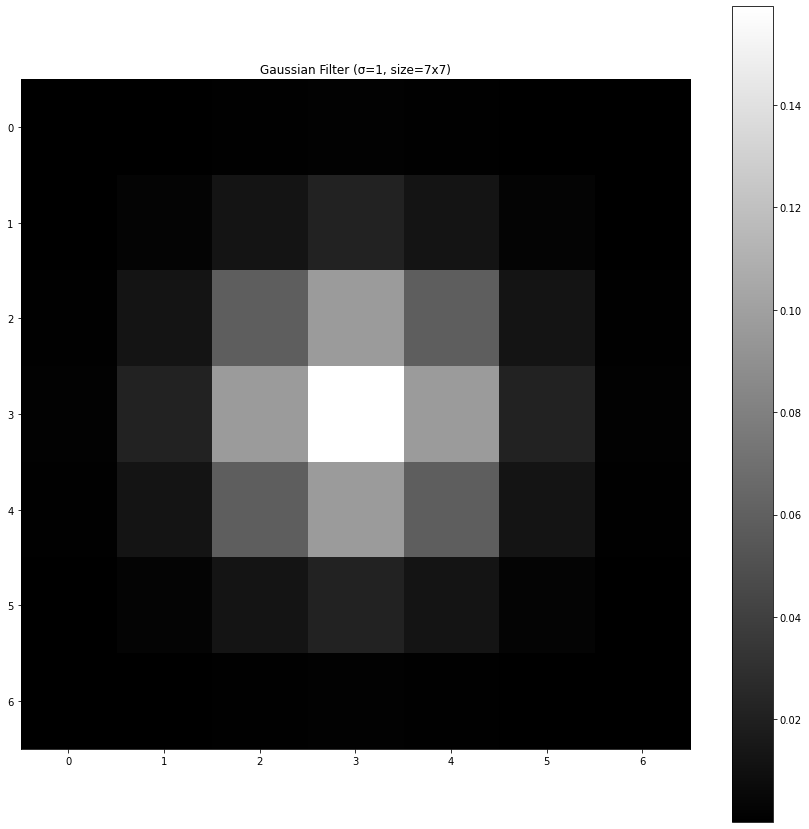

In [14]:
X = np.array(Image.open("grace_600.png").convert('L')).astype(np.float)
  


# Parameters for the Gaussian filter
sigma = 1
support_size = 6 * sigma + 1  # Ensures the support size is sufficient

# Create the Gaussian filter
gaussF = gauss(sigma, support_size)

# Display the Gaussian filter
plt.imshow(gaussF, cmap='gray')
plt.title(f"Gaussian Filter (σ={sigma}, size={support_size}x{support_size})")
plt.colorbar()
plt.show()


**Explanation:**

- **Sigma (`σ`)**: Determines the spread of the Gaussian. A larger sigma results in a more blurred image.
- **Support Size (`supp`)**: The size of the filter kernel. It's set to `6*sigma + 1` to capture the significant part of the Gaussian distribution.
- **Visualization**: The Gaussian filter is visualized to understand its structure.


## Adding and Removing Gaussian Noise

In this section, we'll add Gaussian noise to the image and then attempt to remove it using the Gaussian filter.


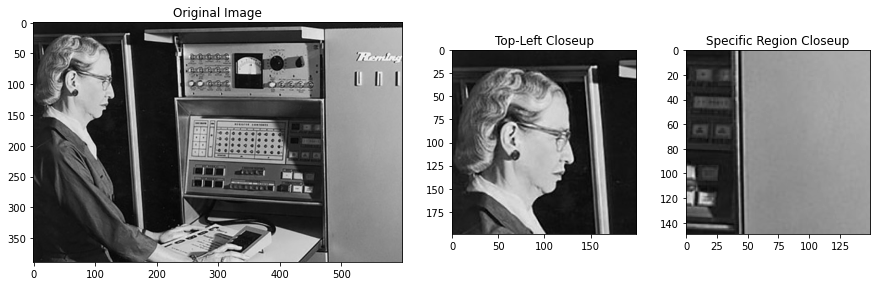

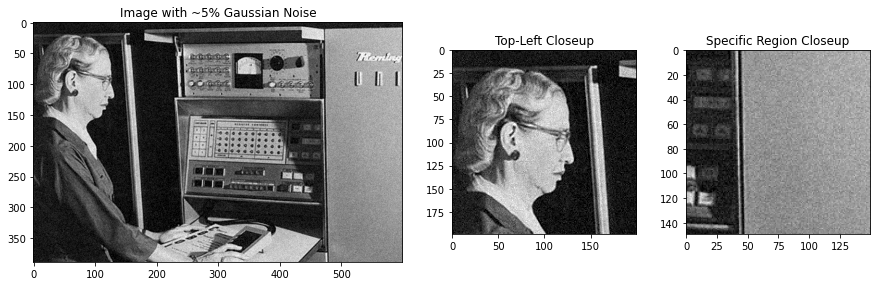

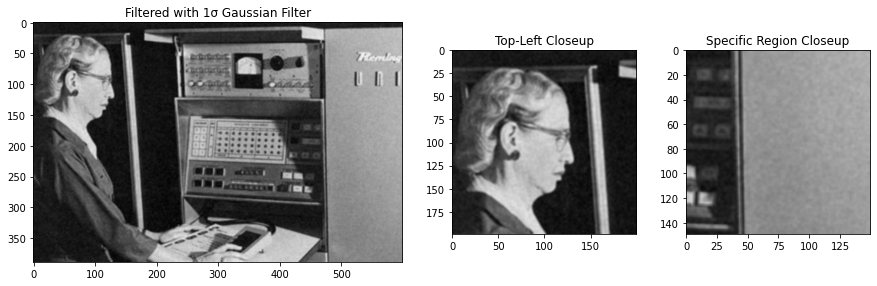

In [15]:
# Option selection
option = "gaussnoise"


# Display Original Image
showGrace(X, title="Original Image")

# Add Gaussian noise (~5% of the pixel value range)
noise_std = 12  # Approximately 5% of 255
XNoise = X + np.random.normal(size=X.shape) * noise_std
showGrace(XNoise, title="Image with ~5% Gaussian Noise")

# Apply Gaussian filter to remove noise
XNoiseFilt = filt(XNoise, gaussF)
showGrace(XNoiseFilt, title="Filtered with 1σ Gaussian Filter")


**Explanation:**

- **Adding Gaussian Noise**: Noise with a standard deviation of 12 is added to simulate real-world imperfections.
- **Filtering**: The noisy image is smoothed using the previously created Gaussian filter to reduce the noise.
- **Visualization**: The original, noisy, and filtered images are displayed for comparison.


## Adding and Removing Salt & Pepper Noise

Next, we'll add salt & pepper noise and then attempt to remove it using both Gaussian and median filters.


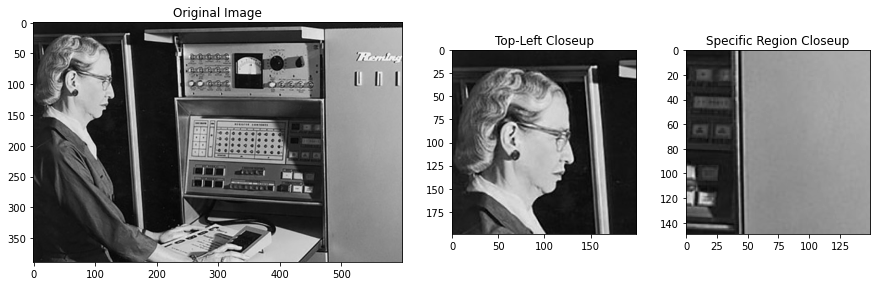

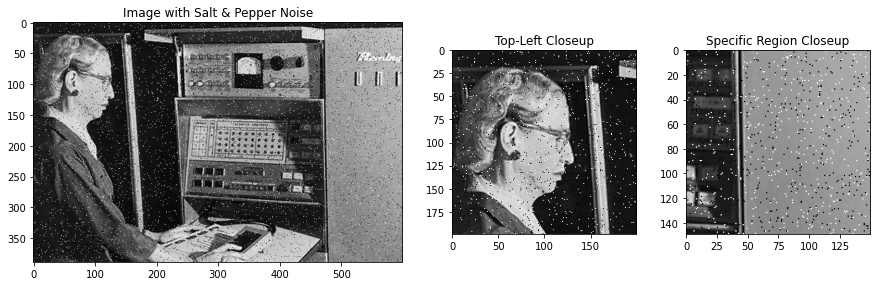

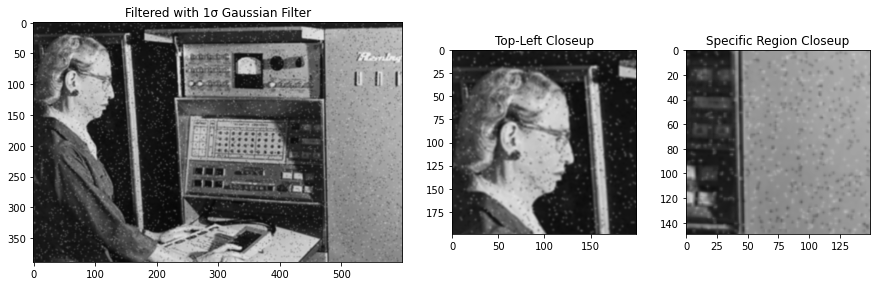

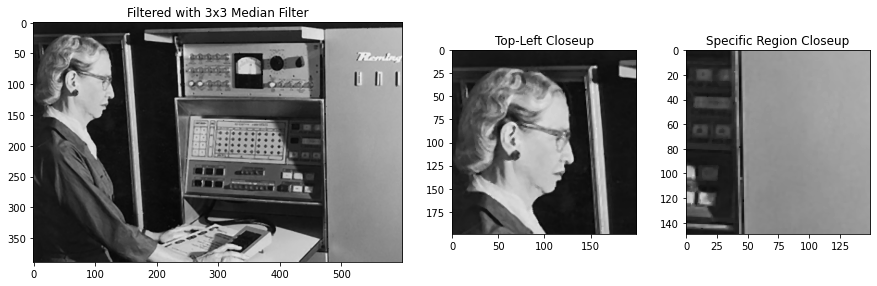

In [16]:
# Display Original Image
showGrace(X, title="Original Image")

# Add Salt & Pepper noise
XSNoise = X.copy()
M = np.random.uniform(size=X.shape)
XSNoise[M < 0.02] = 0       # Pepper noise
XSNoise[M > 0.98] = 255     # Salt noise
showGrace(XSNoise, title="Image with Salt & Pepper Noise")

# Apply Gaussian filter
XSNoiseGFilt = filt(XSNoise, gaussF)
showGrace(XSNoiseGFilt, title="Filtered with 1σ Gaussian Filter")

# Apply Median filter
XSNoiseMFilt = medfilt(XSNoise, size=3)
showGrace(XSNoiseMFilt, title="Filtered with 3x3 Median Filter")


**Explanation:**

- **Adding Salt & Pepper Noise**: Randomly sets a small percentage of pixels to either 0 (pepper) or 255 (salt), simulating impulsive noise.
- **Filtering**:
  - **Gaussian Filter**: Attempts to smooth the noise but may blur edges.
  - **Median Filter**: More effective at removing salt & pepper noise while preserving edges.
- **Visualization**: The original, noisy, and both filtered images are displayed for comparison.


## Image Sharpening

Sharpening enhances the edges and fine details in the image. We'll apply varying degrees of sharpening.


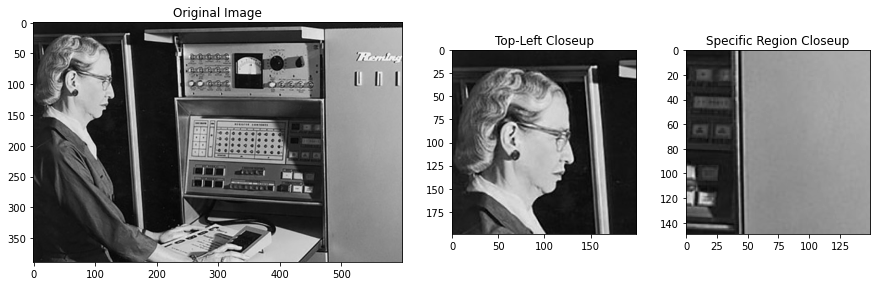

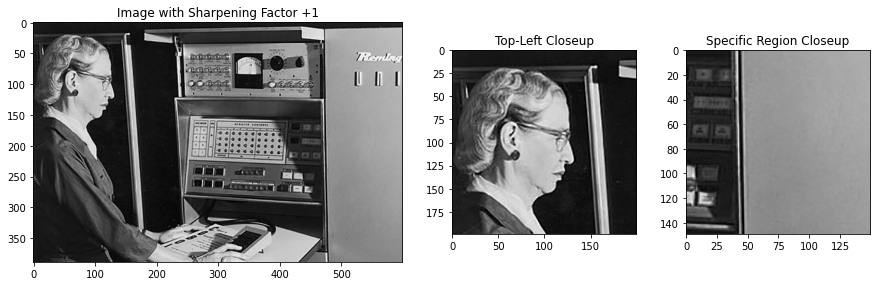

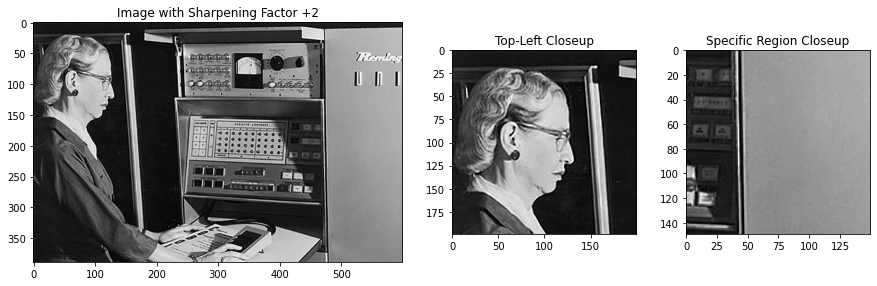

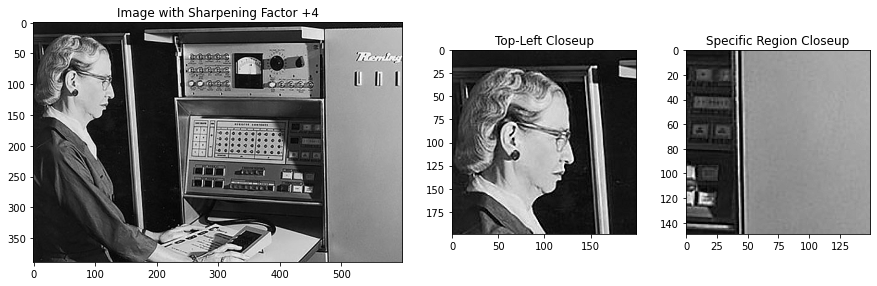

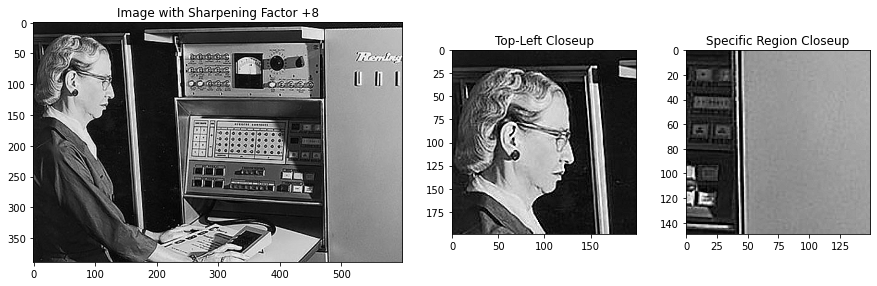

In [17]:
# Option selection
option = "sharpen"

if option == "sharpen":
    # Display Original Image
    showGrace(X, title="Original Image")
    
    # Apply sharpening with different factors
    for factor in [1, 2, 4, 8]:
        sharpened = sharpen(X, factor)
        showGrace(sharpened, title=f"Image with Sharpening Factor +{factor}")


**Explanation:**

- **Sharpening Factors**: Different factors are used to control the intensity of sharpening.
- **Effect**: Higher factors result in more pronounced edges but may introduce artifacts if too high.
- **Visualization**: The original image and its sharpened versions are displayed for comparison.


## Repeated Gaussian Blurring

Applying Gaussian blur multiple times can lead to increased smoothing. We'll observe the effects of repeated blurring.


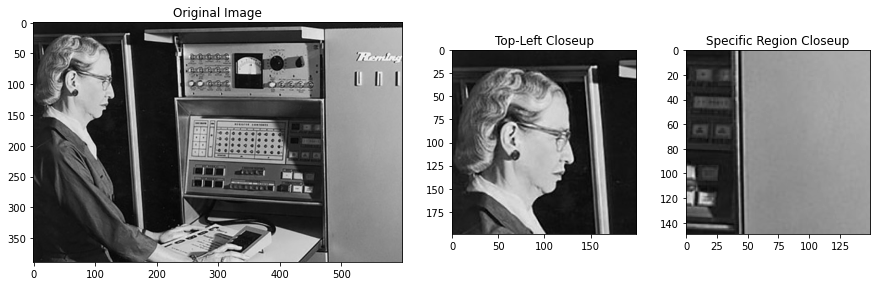

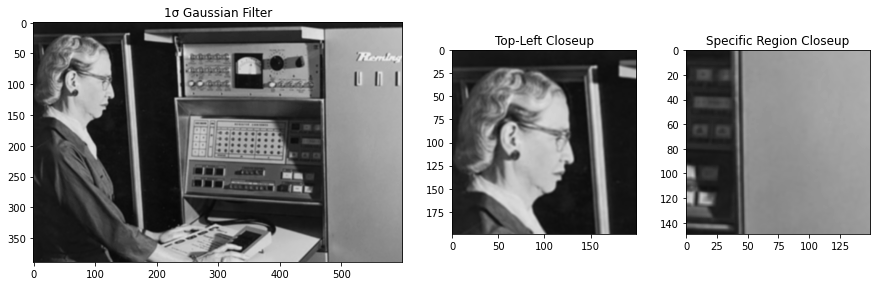

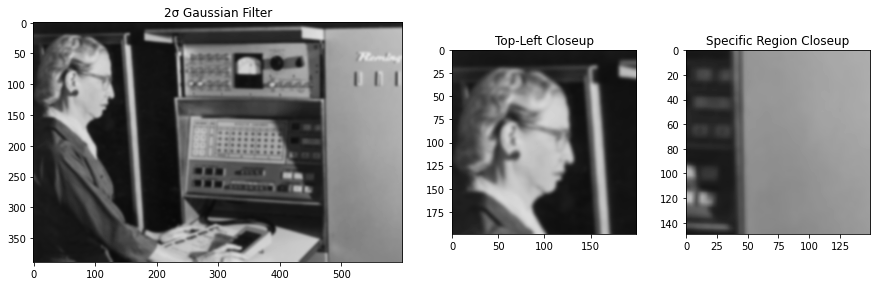

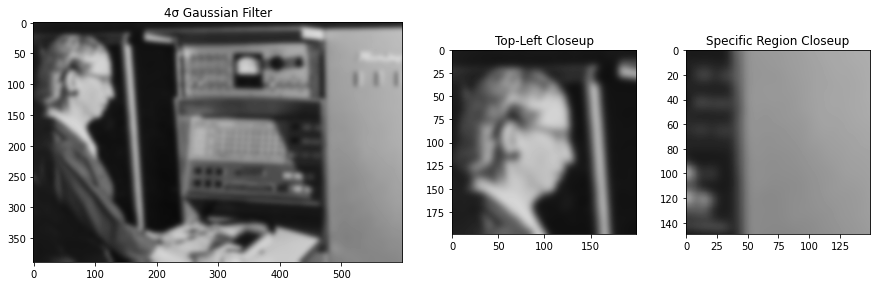

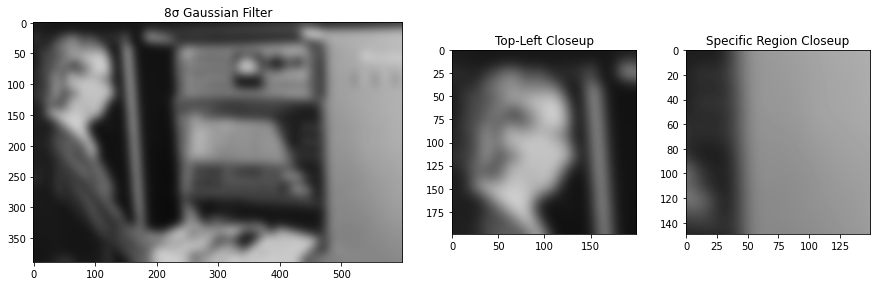

In [18]:
# Display Original Image
showGrace(X, title="Original Image")

# Apply Gaussian blur with increasing sigma
for s in [1, 2, 4, 8]:
    gaussF_s = gauss(s, s * 6 + 1)
    blurred = filt(X, gaussF_s)
    showGrace(blurred, title=f"{s}σ Gaussian Filter")


**Explanation:**

- **Increasing Sigma (`σ`)**: Each subsequent filter has a larger sigma, resulting in more significant blurring.
- **Effect**: Progressive smoothing of the image, which can help in reducing noise but also leads to loss of details.
- **Visualization**: The original and increasingly blurred images are displayed to observe the cumulative effect.


## Conclusion

In this notebook, we've explored various image filtering techniques:

- **Gaussian Filtering**: Effective for reducing Gaussian noise but may blur edges.
- **Median Filtering**: Superior for removing salt & pepper noise while preserving edges.
- **Sharpening**: Enhances image details but requires careful tuning to avoid artifacts.
- **Repeated Blurring**: Demonstrates the cumulative effect of Gaussian filters on image smoothing.

Understanding these techniques is fundamental in image processing, enabling you to manipulate and enhance images for various applications.
